This notebook reports the same experiments as kMICA, but we modified HOSVD, so that it does not perfom the local optimization part when truncation. We did that because we noticed that the projection algorithm (which uses the HOSVD function) returned the same results no matter which core tensor we got from the different MICA experiments. <br>
By doing this we 

### Imports

In [1]:
import sklearn
from sklearn import *
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorly as tl
from tensorly import *
import scipy
import time

Using numpy backend.


### Load the dataset

In [2]:
path = "./data_3_variables/"
n_person = 10
n_view = 9
n_illum = 6
x_size = 200
y_size = 200

images = np.empty((n_person, n_view, n_illum, x_size* y_size))
for im_name in os.listdir(path):
    parsed = im_name.split("_")
    person = int(parsed[0])
    view   = int(-int(parsed[1])/4)
    illum  = int(int(parsed[4])/15)-1
    images[person, view, illum] = cv2.resize(cv2.imread( path+im_name, 0), (x_size, y_size)).reshape(-1)/ 255.

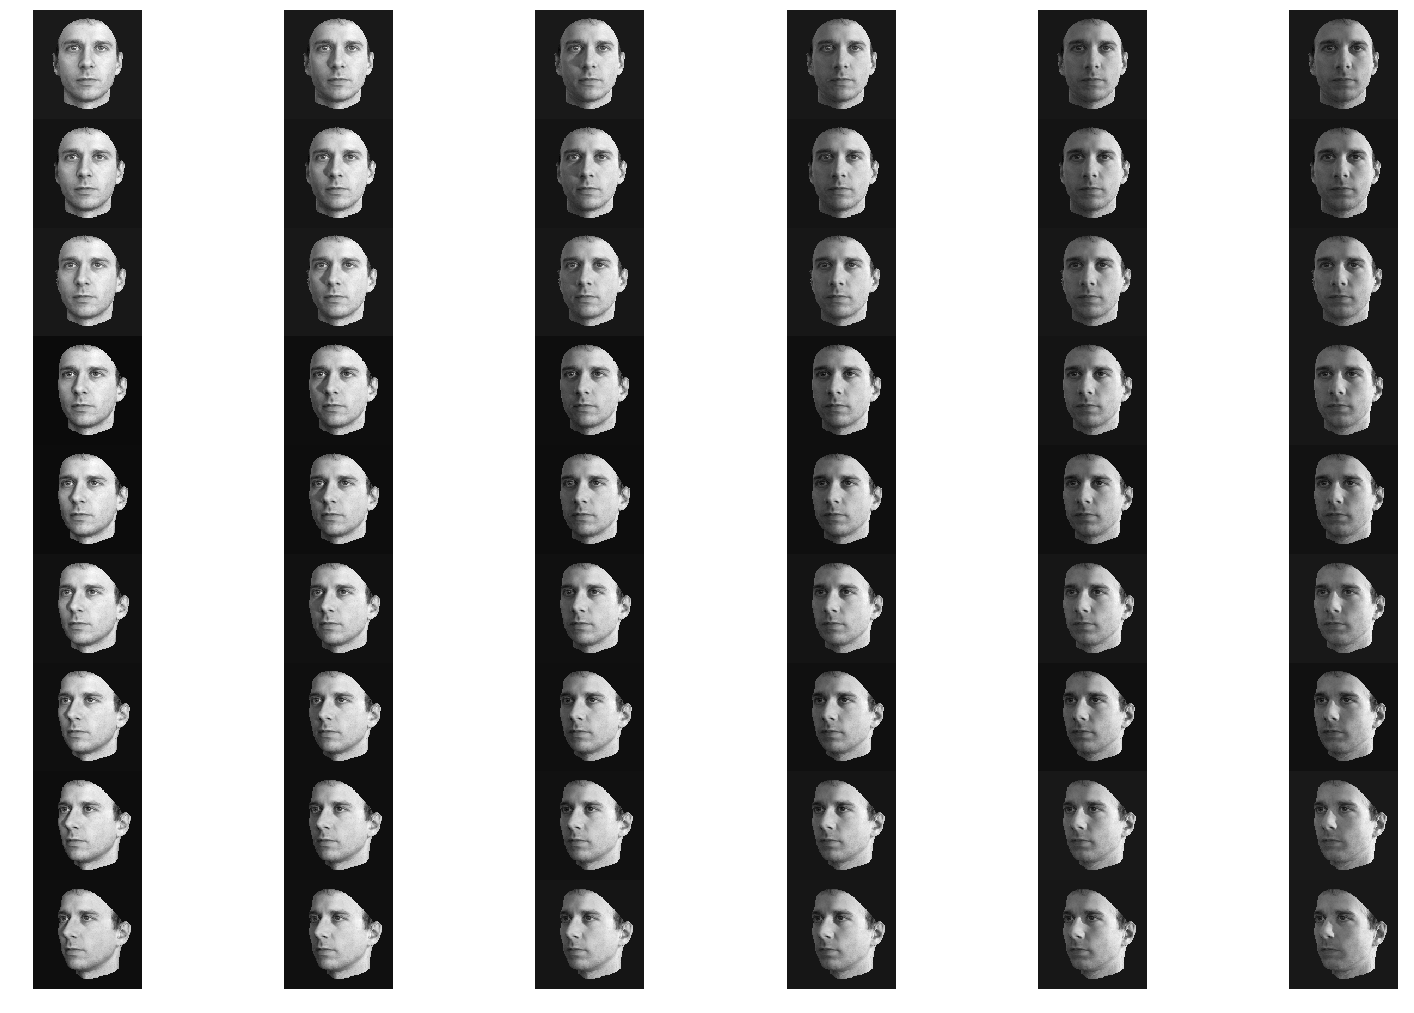

In [3]:
def plot_tensor_slice(T, x_size=x_size, y_size=y_size,  n=0):
    fig = plt.figure(figsize=(3*T.shape[1], 3*T.shape[2]))
    fig.subplots_adjust(wspace=0, hspace=0)
    for i in range(T.shape[1]):
        for j in range(T.shape[2]):
            sub = fig.add_subplot(T.shape[1],T.shape[2],T.shape[2]*i + j+1)
            plt.imshow(T[n,i,j].reshape(x_size, y_size), cmap="gray")
            plt.axis("off")
    plt.show()
plot_tensor_slice(images, n=0)

The dataset we used, was built using 3D scans of 10 differents persons, from which they extracted 200*200 pixels images from 9 different angle of view and 6 different illumination. The image above is the first slice along the person mode of the data tensor, ie all the pictures of the first person. <br><br>
From this data set we will create the training set by removing :
    - the slices along the view point mode of index so that : view_index % 3 == 1
    - the slices along the illumination mode of index so that : illum_index % 2 == 1
It result a training tensor of shape [10, 6, 3, 40000] <br><br>
The test set is the list of images from the data tensor where the index is such that :
    - view_index % 3 == 1  AND illum_index % 3 = 1
It result a list of 90 images.

In [4]:
X_test = []
y_test = []
view_index = [i for i in range(n_view) if i%3 != 1]
illum_index = [i for i in range(n_illum) if i%2 != 1]
n_view2 = len(view_index)
n_illum2 = len(illum_index)
X_train = np.empty((n_person, n_view2, n_illum2, x_size*y_size ))
for i in range(n_person):
    for j in range(n_view):
        for k in range(n_illum):
            if j%3 == 1 and k%2 == 1:
                X_test.append(images[i,j,k])
                y_test.append(i)
            elif j%3 != 1 and k%2 != 1:
                X_train[i, view_index.index(j), illum_index.index(k)] = images[i,j,k]
            else:
                pass
X_test = np.array(X_test).reshape(-1, x_size*y_size)
y_test = np.array(y_test)

The image below is the first slice along the person mode of the training tensor.

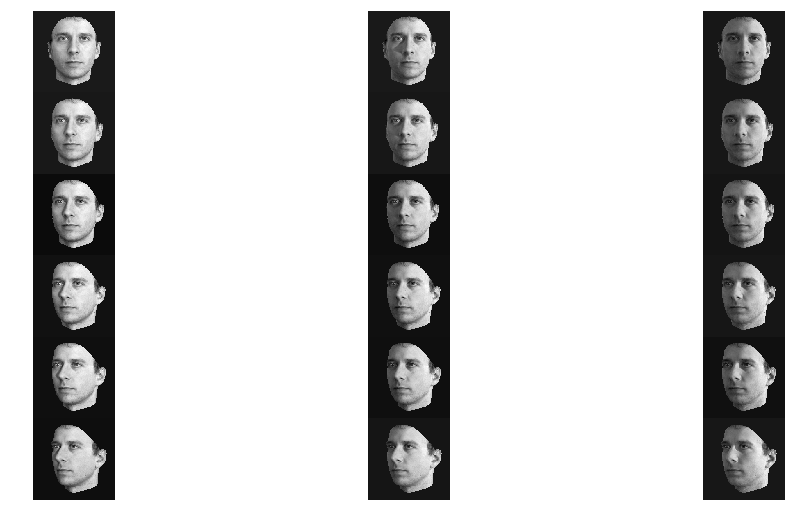

In [5]:
plot_tensor_slice(X_train, n=0)

----------------
#### MPCA

In [6]:
def HOSVD(T, N=None, ranks=None, iter_max=10, e=10 ):
    """ Perform HOSVD on the tensor T on the first n modes of the tensor
        and performs the truncated HOSVD, if ranks is given.
        
        Parameters :
            T :
                    the tensor
            n :
                    set to None by default which perform the HOSVD and all the modes
                    if given must be an int >0, the HOSVD is then performed on the n first modes of T
            ranks : 
                    None by default, if given, must be an array of int of size n, and all of its values must be >0
        Returns (Z, U, U_T, S, V) where :
            Z is the core tensor
            U is the list of U matrices from the SVD
            U is the list of U^T matrices from the SVD
            S is the list of S matrices from the SVD
            V is the list of V matrices from the SVD
    """
    assert isinstance(T, np.ndarray)
    if N is None:
        N = T.ndim
    trunc = True #tells if we perform HOSVD with truncation 
    if ranks is None:
        ranks = np.array(T.shape)[:N]
        trunc = False
    assert N == len(ranks)
    U = list(np.empty(N))
    U_T = list(np.empty(N))
    V = list(np.empty(N))
    S = list(np.empty(N))
    for i in range(N):
        u, s, v = np.linalg.svd( tl.base.unfold(T, i) , full_matrices=False)
        U[i] = u[:, :ranks[i]]
        U_T[i] = u[:, :ranks[i]].T
        S[i] = s[:ranks[i]]
        V[i] = v[:ranks[i]]
    
#     if not trunc:
        #if no truncation, then returns the values
    return tl.tenalg.multi_mode_dot(T, U_T, np.arange(N)), U, U_T, S, V
    
#     prev = float("inf")
#     #otherwise, local optimization using altenating least squares
#     for j in range(iter_max):
#         for n in range(N):
#             # compute X = T x_1 U_1^T ... x_{n-1} U_{n-1}^T x_{n+1} U_{n+1}^T ... x_N U_N^T
#             first = True # a flag that tell if we have already computed T x_1 U_1^T
#             for i in range(N):
#                 if i == n: continue
#                 if first:
#                     first = False
#                     X = tl.tenalg.mode_dot(T, U_T[i], i)
#                 else:
#                     X = tl.tenalg.mode_dot(X, U_T[i], i)
#             U_n, _, _ = np.linalg.svd(tl.base.unfold(X,n), full_matrices=False)
#             U_n = U_n[:,:ranks[n]]
#             U[n] = U_n
#             U_T[n] = U_n.T
#         Z = tl.tenalg.mode_dot(X, U_T[N-1], N-1)
#         T_2 = tl.tenalg.multi_mode_dot(Z, U, np.arange(N))
#         current = np.linalg.norm(T - T_2)**2
#         if abs( current - prev) <= e :
#             break
#         prev = current
#     return  Z, U, U_T, S, V

In [7]:
def cov(M, kernel="linear", degree=2, alpha=1, beta=0, sigma=1 ):
    assert isinstance(M, np.ndarray)
    assert M.ndim == 2
    cov = np.empty((M.shape[0], M.shape[0]))
    for i in range(M.shape[0]):
        for j in range(M.shape[0]):
            if kernel == "linear":
                    cov[i,j] = M[i,:].dot(M.T[:,j])
            elif kernel == "poly":
                cov[i,j] = M[i,:].dot(M.T[:,j])**degree
            elif kernel == "sigmoid":
                cov[i,j] = np.tanh( alpha * M[i,:].dot(M.T[:,j]) + beta )
            elif kernel == "rbf" :
                cov[i,j] = np.exp(- np.linalg.norm(M[i,:] - M.T[:,j])**2)
            else : 
                raise IllegalArgumentError("kernel must be 'linear', 'poly', 'sigmoid', 'rbf'")
    return cov

In [8]:
def MPCA(T, N=None, ranks=None, kernel="linear", iter_max=10, e=10, degree=2, alpha=1, beta=0, sigma=1 ):
    """ Perform MPCA on the tensor T on the first n modes of the tensor
        and performs the truncated MPCA, if ranks is given.
    """
    assert isinstance(T, np.ndarray)
    if N is None:
        N = T.ndim
    trunc = True #tells if we perform HOSVD with truncation 
    if ranks is None:
        ranks = np.array(T.shape)[:N]
        trunc = False
    assert N == len(ranks)
    U = list(np.empty(N))
    U_T = list(np.empty(N))
    V = list(np.empty(N))
    S = list(np.empty(N))
    for i in range(N):
        Tm = tl.base.unfold(T, i)
        u, s, v = np.linalg.svd( cov(Tm, kernel=kernel, degree= degree, alpha=alpha, beta=beta, sigma=sigma ) , full_matrices=False)
        U[i] = u[:, :ranks[i]]
        U_T[i] = u[:, :ranks[i]].T
        S[i] = s[:ranks[i]]
        V[i] = v[:ranks[i]]
    
    return tl.tenalg.multi_mode_dot(T, U_T, np.arange(N)), U, U_T, S, V

In [9]:
def MICA(T, N=None, ranks=None, kernel="linear", fun="logcosh",  iter_max=10, e=10, degree=2, alpha=1, beta=0, sigma=1, max_iter=2000, tol= 1e-2):
    """ Perform MICA on the tensor T on the first n modes of the tensor
        and performs the truncated MICA, if ranks is given.
    """
    assert isinstance(T, np.ndarray)
    if N is None:
        N = T.ndim
    if ranks is None:
        ranks = np.array(T.shape)[:N]
    assert N == len(ranks)
    C_inv = list(np.empty(N))
    for i in range(N):
        covT = cov(tl.base.unfold(T, i), kernel=kernel, degree= degree, alpha=alpha, beta=beta, sigma=sigma)
        u, s, v = np.linalg.svd( covT , full_matrices=False)
        w = sklearn.decomposition.fastica_.fastica(tl.base.unfold(T, i), fun=fun, whiten=True, max_iter=max_iter, tol= tol)[1]
        c = u.dot(np.linalg.inv(w)) [:, :ranks[i]]
        C_inv[i] = np.linalg.pinv(c)
    
    return tl.tenalg.multi_mode_dot(T, C_inv, np.arange(N)), C_inv

In [10]:
def pinv_tensor(T, mode):
    assert isinstance(T, np.ndarray)
    assert T.ndim > mode
    
    Tm = tl.base.unfold(T, mode)
    pinv = np.linalg.pinv(Tm).T
    return tl.base.fold(pinv, mode, T.shape)

In [11]:
def projection_algo(T, v, mode=3):
    
    pinv = pinv_tensor(T, mode)
    respT = tl.tenalg.mode_dot(pinv, v.T, mode)
    return HOSVD(respT, N=3, ranks=[1,1,1])[1]

--------------
### Experiments
For each experiment, we apply MPCA, or MICA with different hyperparameters, on the training tensor. Which return a core tensor. To perform the facial recognition we project 

In [12]:
results = dict()

### Vanilla MPCA

In [15]:
Z, U, U_T, S, V = MPCA(X_train, N=3)

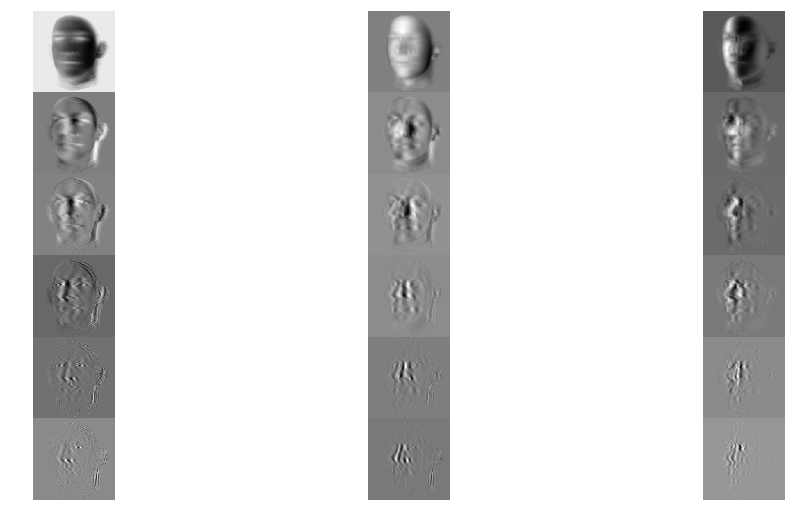

In [16]:
plot_tensor_slice(Z, n=0)

In [17]:
start = time.time()
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)
print(f"elapsed time {time.time() - start}")

elapsed time 200.00081515312195


In [18]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [19]:
exp = "MPCA"
np.save(f"./experiments/{exp}_core_tensor",Z )
np.save(f"./experiments/{exp}_x_train",x_train )
np.save(f"./experiments/{exp}_x_test",x_test )
results[exp] = knn.score(x_test, y_test)
print(f"Accuracy of facial recognition for {exp} = \t{results[exp]}")

Accuracy of facial recognition for MPCA = 	0.8


---------
### MPCA with kernel poly of degree 2

In [20]:
Z, U, U_T, S, V = MPCA(X_train, N=3, kernel="poly", degree=2)

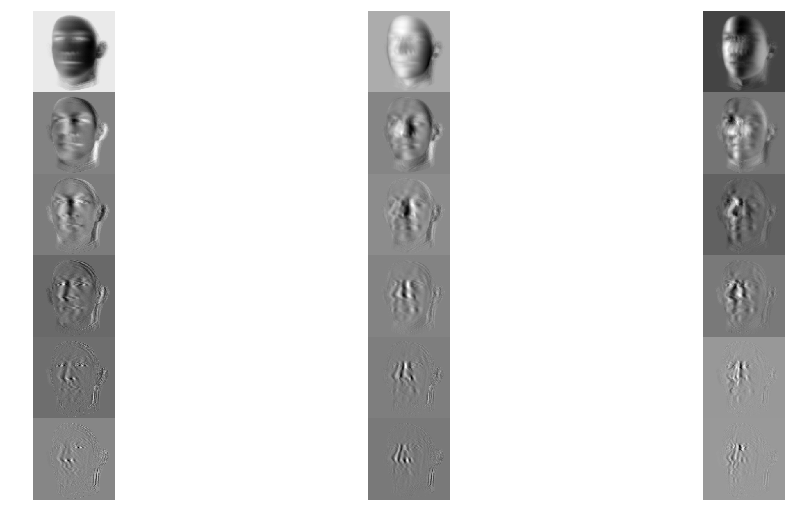

In [21]:
plot_tensor_slice(Z, n=0)

In [22]:
start = time.time()
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)
print(f"elapsed time {time.time() - start}")

elapsed time 195.67067742347717


In [23]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [24]:
exp = "kMPCA_poly2"
np.save(f"./experiments/{exp}_core_tensor",Z )
np.save(f"./experiments/{exp}_x_train",x_train )
np.save(f"./experiments/{exp}_x_test",x_test )
results[exp] = knn.score(x_test, y_test)
print(f"Accuracy of facial recognition for {exp} = \t{results[exp]}")

Accuracy of facial recognition for kMPCA_poly2 = 	0.8111111111111111


---------
### MPCA with kernel sigmoid

In [25]:
Z, U, U_T, S, V = MPCA(X_train, N=3, kernel="sigmoid")

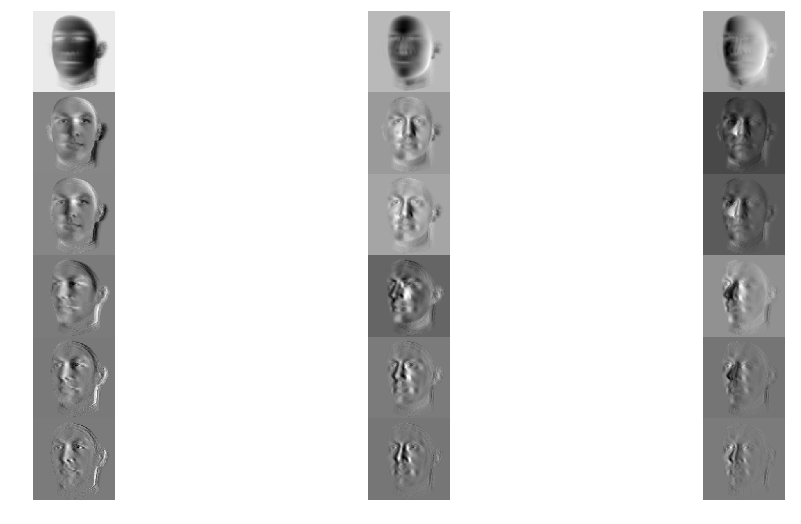

In [26]:
plot_tensor_slice(Z, n=0)

In [27]:
start = time.time()
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)
print(f"elapsed time {time.time() - start}s")

elapsed time 192.61237454414368s


In [28]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [29]:
exp = "kMPCA_sigmoid"
np.save(f"./experiments/{exp}_core_tensor",Z )
np.save(f"./experiments/{exp}_x_train",x_train )
np.save(f"./experiments/{exp}_x_test",x_test )
results[exp] = knn.score(x_test, y_test)
print(f"Accuracy of facial recognition for {exp} = \t{results[exp]}")

Accuracy of facial recognition for kMPCA_sigmoid = 	0.8


---------
### MICA logcosh

In [30]:
Z, C_inv = MICA(X_train, N=3, fun="logcosh", max_iter=int(1e5))

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


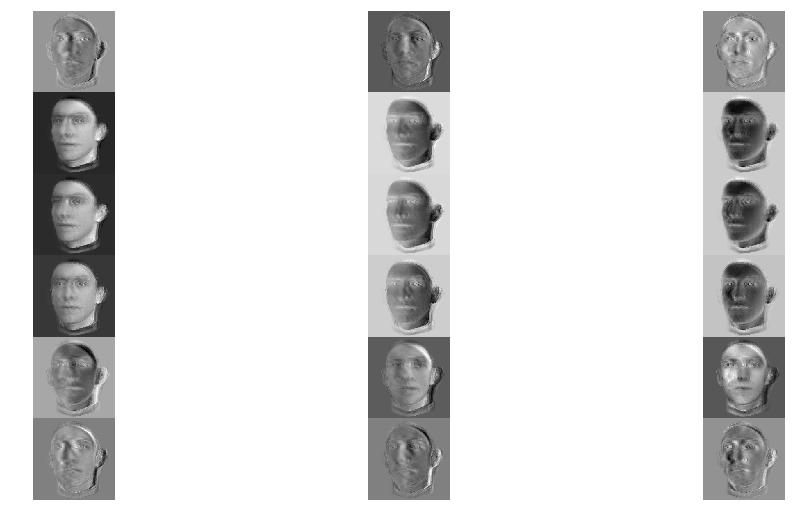

In [31]:
plot_tensor_slice(Z, n=0)

In [32]:
start = time.time()
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)
print(f"elapsed time {time.time() - start}s")

elapsed time 191.30311179161072s


In [33]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [34]:
exp = "MICA_logcosh"
np.save(f"./experiments/{exp}_core_tensor",Z )
np.save(f"./experiments/{exp}_x_train",x_train )
np.save(f"./experiments/{exp}_x_test",x_test )
results[exp] = knn.score(x_test, y_test)
print(f"Accuracy of facial recognition for {exp} = \t{results[exp]}")

Accuracy of facial recognition for MICA_logcosh = 	0.7111111111111111


---------
### MICA with exp function for negentropy

In [35]:
Z, C_inv = MICA(X_train, N=3, fun="exp", max_iter=int(1e5))

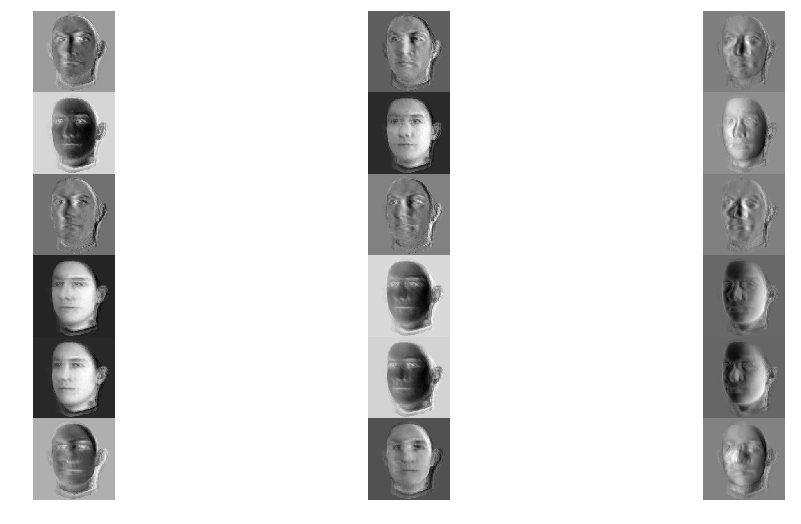

In [36]:
plot_tensor_slice(Z, n=0)

In [37]:
start = time.time()
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)
print(f"elapsed time {time.time() - start}s")

elapsed time 189.85038304328918s


In [38]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [39]:
exp = "MICA_exp"
np.save(f"./experiments/{exp}_core_tensor",Z )
np.save(f"./experiments/{exp}_x_train",x_train )
np.save(f"./experiments/{exp}_x_test",x_test )
results[exp] = knn.score(x_test, y_test)
print(f"Accuracy of facial recognition for {exp} = \t{results[exp]}")

Accuracy of facial recognition for MICA_exp = 	0.7333333333333333



---------
### MICA logcosh poly 2

In [40]:
Z, C_inv = MICA(X_train, N=3, fun="logcosh", kernel="poly", degree=2)

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [41]:
start = time.time()
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)
print(f"elapsed time {time.time() - start}s")

elapsed time 189.1453037261963s


In [42]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [43]:
exp = "kMICA_logcosh_poly2"
np.save(f"./experiments/{exp}_core_tensor",Z )
np.save(f"./experiments/{exp}_x_train",x_train )
np.save(f"./experiments/{exp}_x_test",x_test )
results[exp] = knn.score(x_test, y_test)
print(f"Accuracy of facial recognition for {exp} = \t{results[exp]}")

Accuracy of facial recognition for kMICA_logcosh_poly2 = 	0.6777777777777778


---------
### MICA logcosh sigmoid

In [44]:
Z, C_inv = MICA(X_train, N=3, fun="logcosh", kernel="sigmoid")

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [45]:
start = time.time()
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)
print(f"elapsed time {time.time() - start}s")

elapsed time 191.17834377288818s


In [46]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [47]:
exp = "kMICA_logcosh_sigmoid"
np.save(f"./experiments/{exp}_core_tensor",Z )
np.save(f"./experiments/{exp}_x_train",x_train )
np.save(f"./experiments/{exp}_x_test",x_test )
results[exp] = knn.score(x_test, y_test)
print(f"Accuracy of facial recognition for {exp} = \t{results[exp]}")

Accuracy of facial recognition for kMICA_logcosh_poly2 = 	0.7111111111111111


### Results

In [48]:
print("{:20}\t{}".format("Model","Accuracy"))
for key in results.keys():
    print("{:20}\t{:.4f}".format(key,results[key]))

Model               	Accuracy
MPCA                	0.8000
kMPCA_poly2         	0.8111
kMPCA_sigmoid       	0.8000
MICA_logcosh        	0.7111
MICA_exp            	0.7333
kMICA_logcosh_poly2 	0.6778
kMICA_logcosh_sigmoid	0.7111
